In [1]:
import importlib

%load_ext autoreload
%autoreload 2

In [2]:
%load_ext dotenv
%dotenv

In [3]:
import os
from dotenv import load_dotenv

load_dotenv() 
ROOT = os.getenv("ROOT")
DATA = os.getenv("DATA")
SCRIPTS = os.getenv("SCRIPTS")

# Make root
os.chdir(SCRIPTS)
print(os.getcwd())

/home/callebalik/clinical_NLP_SE/scripts


In [4]:

from pathlib import Path
import pandas as pd
import numpy as np

from metrics.conll2003_utills import create_total_target_vector, conll2003_to_df, get_cleaned_label, create_total_target_df
from metrics.confusion_matrix import generate_confusion_matrix


a1 = create_total_target_df(Path(f"{DATA}/interim/corpus/a1"))
a2 = create_total_target_df(Path(f"{DATA}/interim/corpus/a2"))

# [get_cleaned_label(label) for label in df["NE"]]
# dict = {"a1":a1, "a2":a2}


df = pd.DataFrame()
c = ["TOKEN", "NE"]
df["TOKEN"] = a1["TOKEN"]

df.insert(1, "NE_a1", a1["NE"])
df.insert(2, "NE_a2", a2["NE"])

# Get all that does not contain DIS labels
df_sfno = (df[~df.NE_a1.str.contains("DIS") & ~df.NE_a2.str.contains("DIS")]) 

df_sfno["A1"] = [get_cleaned_label(label) for label in df_sfno["NE_a1"]]
df_sfno["A2"] = [get_cleaned_label(label) for label in df_sfno["NE_a2"]]

/tmp/ipykernel_717/2724057387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfno["A1"] = [get_cleaned_label(label) for label in df_sfno["NE_a1"]]
/tmp/ipykernel_717/2724057387.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfno["A2"] = [get_cleaned_label(label) for label in df_sfno["NE_a2"]]


In [8]:
values = ['SYM/FND', "NEG", "O"]

conditions = [
    (df_sfno.A1.str.contains("FND")) | (df_sfno.A1.str.contains("SYM")),
    (df_sfno.A1.str.contains("NEG")),
    (df_sfno.A1.str.contains("O"))
     ]

df_sfno['A1_sf'] = np.select(conditions, values)

conditions = [
    (df_sfno.A2.str.contains("FND")) | (df_sfno.A2.str.contains("SYM")), 
    (df_sfno.A2.str.contains("NEG")),
    (df_sfno.A2.str.contains("O"))
     ]

df_sfno['A2_sf'] = np.select(conditions, values)

df_sfno[df_sfno.A2_sf.str.contains("SYM")]

/tmp/ipykernel_717/3852444184.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfno['A1_sf'] = np.select(conditions, values)
/tmp/ipykernel_717/3852444184.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfno['A2_sf'] = np.select(conditions, values)


TOKEN  NE_a1  NE_a2   A1   A2    A1_sf    A2_sf
4 36         agiterat      O  I-FND    O  FND        O  SYM/FND
  47           kräkts  I-FND  I-SYM  FND  SYM  SYM/FND  SYM/FND
  51   svårkontaktbar  B-FND  B-SYM  FND  SYM  SYM/FND  SYM/FND
  96         takykard  B-FND  I-FND  FND  FND  SYM/FND  SYM/FND
  100        blåsljud  I-FND  B-FND  FND  FND  SYM/FND  SYM/FND
...               ...    ...    ...  ...  ...      ...      ...
2 193        blåmärke  B-FND  B-FND  FND  FND  SYM/FND  SYM/FND
  198    utåtrotation  I-FND  I-FND  FND  FND  SYM/FND  SYM/FND
  211          acidos  B-FND  B-FND  FND  FND  SYM/FND  SYM/FND
  239        blödning  I-FND  I-FND  FND  FND  SYM/FND  SYM/FND
  252          febril  B-FND  B-FND  FND  FND  SYM/FND  SYM/FND

[174 rows x 7 columns]

In [36]:
from pathlib import Path

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

import pandas as pd 

from metrics.conll2003_utills import create_total_target_vector


# a1 = df_sfno.A1_sf
# a2 = df_sfno.A2_sf

a1 = df_sfno.A1
a2 = df_sfno.A2

classes = ["SYM/FND","NEG","O"]
classes = ["SYM","FND","NEG","O"]

print(f"Cohen Kappa {cohen_kappa_score(a1, a2)}")
cr = classification_report(a1,a2, labels=classes, output_dict=True)
cr = pd.DataFrame.from_dict(cr)

print(classification_report(a1,a2, labels=classes)) # IF not as dict, it can be neatly printed
metrics = ["precision","recall","f1-score"]
df_print =  cr.loc[metrics,classes]

print(df_print.T.to_latex(float_format="{:0.2f}".format))



Cohen Kappa 0.8405168266477285
              precision    recall  f1-score   support

         SYM       0.64      0.74      0.69        46
         FND       0.85      0.69      0.76       149
         NEG       0.95      0.95      0.95        74
           O       0.98      0.99      0.99      2021

    accuracy                           0.97      2290
   macro avg       0.86      0.84      0.85      2290
weighted avg       0.97      0.97      0.97      2290

\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
\midrule
SYM &       0.64 &    0.74 &      0.69 \\
FND &       0.85 &    0.69 &      0.76 \\
NEG &       0.95 &    0.95 &      0.95 \\
O   &       0.98 &    0.99 &      0.99 \\
\bottomrule
\end{tabular}



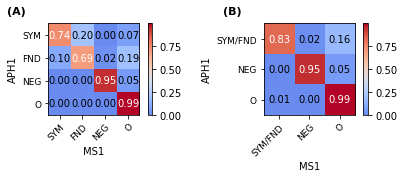

<Figure size 640x480 with 0 Axes>

In [37]:


from plot_confusion_matrix import plot_confusion_matrix


from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.gridspec as gridspec


top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

viridisBig = cm.get_cmap('viridis_r', 512)
viridis_new = ListedColormap(viridisBig(np.linspace(0.15, 1, 256)))

viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:5, :] = pink
newcmp = ListedColormap(newcolors)

coolw = cm.get_cmap('coolwarm', 512)
coolw_new = ListedColormap(coolw(np.linspace(0.15, 1, 256)))

color = coolw_new
color = plt.cm.YlGnBu
# color = plt.cm.coo


classes1 = ["SYM", "FND","NEG","O"]

classes2 = ["SYM/FND","NEG","O"]

font = {#'family': 'serif',
        # 'color':  'black',
        #'weight': 'normal',
        'size': 10,
        }

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
cm = 1/2.54  # centimeters in inches
# Providing the axs
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(40*cm, 10*cm), constrained_layout=True)
# # First subplt
# cm1, ax1, im1 = plot_confusion_matrix(df_sfno.A1, df_sfno.A2, classes1, ax=axs[0], normalize=True)
# axs[0].figure.colorbar(im1, ax=axs[0], fraction=0.05)
# # Second subplt
# cm2, ax2, im2 = plot_confusion_matrix(df_sfno.A1_sf, df_sfno.A2_sf, classes2, ax=axs[1], normalize=True)
# axs[1].figure.colorbar(im2, ax=axs[1], fraction=0.15)



fig2 = plt.figure(tight_layout=True)
spec2 = gridspec.GridSpec(2,2)

f2_ax1 = fig2.add_subplot(spec2[0])
f2_ax2 = fig2.add_subplot(spec2[1])

axs = [f2_ax1,f2_ax2]

cm1, ax1, im1 = plot_confusion_matrix(df_sfno.A1, df_sfno.A2, classes1, ax=axs[0], normalize=True, cmap=coolw_new)
axs[0].figure.colorbar(im1, ax=axs[0], fraction=0.05)
# Second subplt
cm2, ax2, im2 = plot_confusion_matrix(df_sfno.A1_sf, df_sfno.A2_sf, classes2, ax=axs[1], normalize=True, cmap=coolw_new)
axs[1].figure.colorbar(im2, ax=axs[1], fraction=0.05)



[ax.set(title=None) for ax in axs]
[ax.set_xlabel(xlabel='MS1', fontdict=font) for ax in axs]
[ax.set_ylabel(ylabel='APH1', fontdict=font) for ax in axs]

axs = fig2.get_axes()
texts = ['(A)', '(B)']
for a,l in zip(axs, texts):

    # X = a.get_position().x0
    # Y = a.get_position().y1    
    # fig2.text(X - .1, Y + .018, l, size=10, weight='bold')
    a.annotate(l, xy=(-0.45, 1.1), xycoords="axes fraction", fontsize=11, weight = 'bold')
# plt.subplots_adjust(left=-0.45)

# plt.tight_layout() #This to avoid overlap of labels and titles across plots

plt.show()

plt.savefig(f"{DATA}/processed/IAA_SYM_FND", )

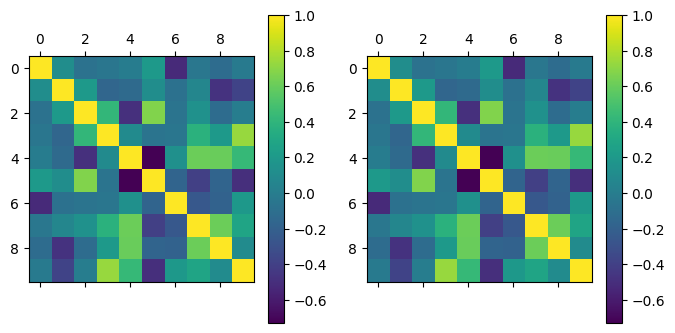

In [82]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

df = pd.DataFrame(np.random.rand(10, 10))

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax1, ax2 = axes

im1 = ax1.matshow(df.corr())
im2 = ax2.matshow(df.corr())

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [81]:
from matplotlib import pyplot
from matplotlib import cm

def corr_heatmaps(data1, data2, method='pearson'):

    # Basic Configuration
    fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
    ax1, ax2 = axes
    corr_matrix1 = data1.corr(method=method)
    corr_matrix2 = data2.corr(method=method)
    columns1 = corr_matrix1.columns
    columns2 = corr_matrix2.columns

    # Heat maps.
    im1 = ax1.matshow(corr_matrix1, cmap='coolwarm')
    im2 = ax2.matshow(corr_matrix2, cmap='coolwarm')

    # Formatting for heat map 1.
    ax1.set_xticks(range(len(columns1)))
    ax1.set_yticks(range(len(columns1)))
    ax1.set_xticklabels(columns1)
    ax1.set_yticklabels(columns1)
    ax1.set_title(data1.name, y=-0.1)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
    plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax1)

    # Formatting for heat map 2.
    ax2.set_xticks(range(len(columns2)))
    ax2.set_yticks(range(len(columns2)))
    ax2.set_xticklabels(columns2)
    ax2.set_yticklabels(columns2)
    ax2.set_title(data2.name, y=-0.1)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
    plt.colorbar(im2, fraction=0.045, pad=0.05, ax=ax2)

    fig.tight_layout()

In [7]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

import pandas as pd 

a1 = df_sfno["A1"]
a2 = df_sfno["A2"]


classes = ["SYM","FND","NEG","O"]
rows = ["precision","recall","f1-score"]
print(f"Cohen Kappa {cohen_kappa_score(a1, a2)}")
cr = classification_report(a1,a2, labels=classes, output_dict=True)
cr = pd.DataFrame.from_dict(cr)

report = cr.loc[rows,classes]
report.to_latex()

specifier = str(classes)
with open(f"{DATA}/processed/classification_report_sym_fnd.tex","x") as latex:
    latex.write(report.to_latex())

Cohen Kappa 0.8405168266477285


FileExistsError: [Errno 17] File exists: '/home/callebalik/clinical_NLP_SE/data/processed/classification_report_sym_fnd.tex'

In [8]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

import pandas as pd 

a1 = df_sfno["A1_sf"]
a2 = df_sfno["A2_sf"]


classes = ["SYM/FND","NEG","O"]
rows = ["precision","recall","f1-score"]
print(f"Cohen Kappa {cohen_kappa_score(a1, a2)}")
cr = classification_report(a1,a2, labels=classes, output_dict=True)
cr = pd.DataFrame.from_dict(cr)

report = cr.loc[rows,classes]
report.to_latex()

specifier = str(classes)
with open(f"{DATA}/processed/classification_report_symfnd.tex","x") as latex:
    latex.write(report.to_latex())

Cohen Kappa 0.8895169101847076


In [13]:
from pathlib import Path
import pandas as pd

from metrics.conll2003_utills import create_total_target_vector
from metrics.confusion_matrix import generate_confusion_matrix

a1 = create_total_target_vector(Path(f"{DATA}/interim/corpus/a1"))
a2 = create_total_target_vector(Path(f"{DATA}/interim/corpus/a2"))

dict = {"a1":a1, "a2":a2}
df = pd.DataFrame(dict)


classes = ["SYM","FND","NEG","DIS","O"]
cm = generate_confusion_matrix(a1, a2, classes)

df

,a1,a2
0,O,O
1,O,O
2,DIS,SYM
3,O,O
4,O,O
...,...,...
2333,O,O
2334,O,O
2335,DIS,DIS
2336,O,O


In [21]:
from pathlib import Path
import spacy

from metrics.spacy_utills import create_total_prediction_vector
from metrics.spacy_utills import create_prediction_vector

corpus = Path(f"{DATA}/raw/corpus/curation")

nlp = spacy.load("sv_pipeline")

docs = []

pathlist = Path(corpus).glob("**/*.conll")

for path in pathlist:
    create_prediction_vector()

create_total_prediction_vector(nlp, docs)

/home/callebalik/clinical_NLP_SE/data


In [ ]:
def get_dataset_labels(annotation_set):
    return sorted(set(create_total_target_vector(annotation_set)))

In [ ]:
from plot_confusion_matrix import plot_confusion_matrix

classes = ["SYM","FND","NEG","DIS","O"]

plot_confusion_matrix(a1, a2, classes=classes, normalize=True, xlabel="annotator2", ylabel="annotator1")